# 1.	特征人脸识别

# 1. 实验介绍

## 1.1  实验背景

本实验采用特征脸（Eigenface）算法进行人脸识别。

特征脸（eigenface）是第一种有效的人脸识别方法，通过在一大组描述不同人脸的图像上进行主成分分析（PCA）获得。
本次实验要求大家构建一个自己的人脸库（建议）：大家可以选择基于ORL人脸库添加自己搜集到的人脸图像形成一个更大的人脸库，要求人脸库中的每一张图像都只包含一张人脸且眼睛的中心位置对齐(通过裁剪或缩放，使得每张人脸图像大小尺寸一致且人脸眼睛的中心位置对齐)。为了方便同学们操作，大家也可以选择直接基于ORL人脸库进行本次实验。

## 1.2  实验内容

在模型训练过程中，首先要根据测试数据求出平均脸，然后将前 K 个特征脸保存下来，利用这 K 个特征脸对测试人脸进行识别，此外对于任意给定的一张人脸图像，可以使用这K个特征脸对原图进行重建。

## 1.3 实验要求

1. 求解人脸图像的特征值与特征向量构建特征脸模型
2. 利用特征脸模型进行人脸识别和重建，比较使用不同数量特征脸的识别与重建效果
3. 使用 Python 语言

参考资料：  
+ [特征脸 - 维基百科](https://zh.wikipedia.org/wiki/%E7%89%B9%E5%BE%81%E8%84%B8)
+ [Eigenface for Recognition](https://sites.cs.ucsb.edu/~mturk/Papers/jcn.pdf)
+ [ORL](http://cam-orl.co.uk/facedatabase.html)
+ [The Yale Face Database](http://cvc.cs.yale.edu/cvc/projects/yalefaces/yalefaces.html)

## 1.4 注意事项

+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。

## 1.5 作业提交  

+ 在左侧 `提交作业` 的标签中，把第三节中勾选四个cell模块(在各模块上方有提示"在生成 main 文件时, 请勾选该模块") 转化为 main.py 文件进行`系统测试`。
+ 能通过测试就可以**提交作业**。 


# 2. 数据准备

本次实验要求大家构建一个自己的人脸库（建议）：    
大家可以选择基于ORL人脸库添加自己搜集到的人脸图像形成一个更大的人脸库，要求人脸库中的每一张图像都只包含一张人脸且眼睛的中心位置对齐(通过裁剪或缩放，使得每张人脸图像大小尺寸一致且人脸眼睛的中心位置对齐)。

为了方便同学们操作，大家也可以选择直接基于 ORL 人脸库进行本次实验。

本作业中使用的基础人脸库来自 [ORL](http://cam-orl.co.uk/facedatabase.html)。整个数据集包含来自 40 名志愿者的 280 张照片，每名志愿者的照片都包含 7 个不同的表情和角度。

## 2.1 导入必要的包

In [1]:
# 导入必要的包
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os

## 2.2 数据加载

In [7]:
def spilt_data(nPerson, nPicture, data, label):
    """
    分割数据集
    
    :param nPerson : 志愿者数量
    :param nPicture: 各志愿者选入训练集的照片数量
    :param data : 等待分割的数据集
    :param label: 对应数据集的标签
    :return: 训练集, 训练集标签, 测试集, 测试集标签
    """
    # 数据集大小和意义
    allPerson, allPicture, rows, cols = data.shape
    #print(label.shape)
    # 划分训练集和测试集
    train = data[:nPerson,:nPicture,:,:].reshape(nPerson*nPicture, rows*cols)
    train_label = label[:nPerson, :nPicture].reshape(nPerson * nPicture)
    test = data[:nPerson, nPicture:, :, :].reshape(nPerson*(allPicture - nPicture), rows*cols)
    test_label = label[:nPerson, nPicture:].reshape(nPerson * (allPicture - nPicture))

    # 返回: 训练集, 训练集标签, 测试集, 测试集标签
    return train, train_label, test, test_label

In [8]:
datapath = './ORL.npz'
ORL = np.load(datapath)
data = ORL['data']
label = ORL['label']

print("数据格式(志愿者数, 各志愿者人脸数, height, width):", data.shape)
print("标签格式(志愿者数, 各志愿者人脸数):", label.shape)

train_vectors, train_label, test_vectors, test_label = spilt_data(40, 5, data,label)
print("训练数据集:", train_vectors.shape)
print("测试数据集:", test_vectors.shape)

数据格式(志愿者数, 各志愿者人脸数, height, width): (40, 7, 112, 92)
标签格式(志愿者数, 各志愿者人脸数): (40, 7)
(40, 7, 112, 92)
训练数据集: (200, 10304)
测试数据集: (80, 10304)


## 2.3 展示图片

In [17]:
def show_img(img, h=112, w=92):
    """
    展示单张图片
    
    :param img: numpy array 格式的图片
    :return: 
    """
    # 展示图片
    plt.imshow(img.reshape(h, w), 'gray')
    plt.axis('off')
    plt.show()

def plot_gallery(images, titles, n_row=3, n_col=5, h=112, w=92):  # 3行4列
    """
    展示多张图片
    
    :param images: numpy array 格式的图片
    :param titles: 图片标题
    :param h: 图像reshape的高
    :param w: 图像reshape的宽
    :param n_row: 展示行数
    :param n_col: 展示列数
    :return: 
    """
    # 展示图片
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

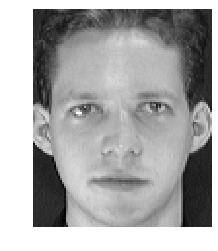

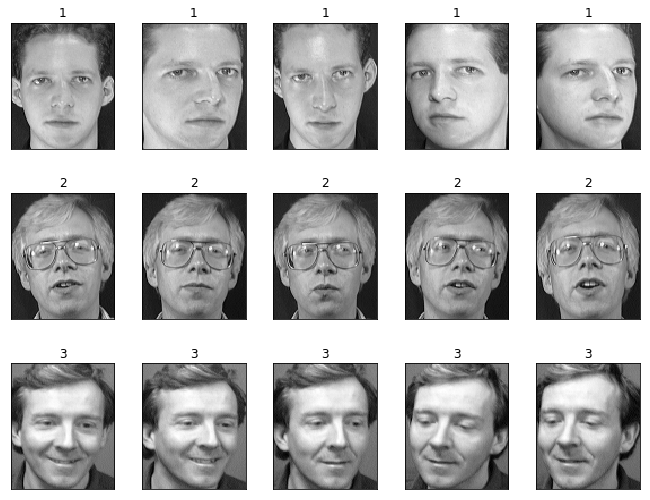

In [18]:
# 展示单张图片
show_img(train_vectors[0])

# 展示多张图片
plot_gallery(train_vectors, train_label)

## 2.4 调整图片大小

In [6]:
def letterbox_image(image, size):
    """
    调整图片尺寸
    :param image: 用于训练的图片
    :param size: 需要调整到网络输入的图片尺寸
    :return: 返回经过调整的图片
    """
    new_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    return new_image

In [7]:
# 使用 PIL.Image 读取图片
img = np.array(data[1,1,:,:])
print("调整前图片的尺寸:", img.shape)
img = letterbox_image(image=img, size=(50, 50))
img = np.array(img)
print("调整前图片的尺寸:", img.shape)

调整前图片的尺寸: (112, 92)
调整前图片的尺寸: (50, 50)


## 2.5 增加数据库

In [ ]:
def read_one_img(path):
    """
    根据路径读取一张人脸图片
    
    :param path: 图片的路径
    :return: 
    """
    # 图片路径
    # 以灰度模式读取图片
    img_sample = Image.open(path).convert('L')
    
    # 把图片格式转为 numpy array 格式
    img_sample = np.array(img_sample, 'uint8')
    
    return img_sample

def get_images(path):
    """
    读取输入的文件夹路径下的所有照片，读取输入的文件夹路径下的所有照片，将其转为 1 维，
    统一保存到一个矩阵中，然依据图片名提取标签，最终该函数将输出这个照片矩阵及其中每
    张照片的标签。
    
    照片的命名格式请参照"person41_01.png", 其含义为第41位志愿者的第01张人脸图像。
    
    :param path: 照片存放的文件夹路径
    :return: numpy matrix 格式的处理好的图片，及 list 格式的各个图片的标签
    """
    # 首先获取所有人脸图片的路径
    image_paths = [os.path.join(path, f) for f in os.listdir(path) if
                   f.endswith('png')]
    
    # 所有的人脸区域图片都将保存在 images 这个矩阵中
    images = np.mat(np.zeros((len(image_paths), 112 * 92)))
    
    trainset_labels = []
    
    # 对于每一张图片
    for index, image_path in enumerate(image_paths):
        
        # 读取图片并将其转为灰度图
        image_pil = Image.open(image_path).convert('L')
        
        # 把图片转为 numpy array 格式
        image = np.array(image_pil, 'uint8')
        image = letterbox_image(image=image, size=(112, 92))
        
        # 把 2 维的平面图像转为 1 维
        img_1D = image.flatten()
        
        # 把处理后的图片保存到 images 中
        images[index, :] = img_1D
        
        # 提取图片名作为图片的标签
        trainset_labels.append(int(image_path.split('.')[-2][-2:]))
        
    # 得到最终处理好的人脸图片和各个图片的标签
    trainset_labels = np.array(trainset_labels)
    return images, trainset_labels

# 3. 构建特征脸模型

## 3.1 数据预处理

In [ ]:
# 在生成 main 文件时, 请勾选该模块

# 导入必要的包
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os

def spilt_data(nPerson, nPicture, data, label):
    """
    分割数据集
    
    :param nPerson : 志愿者数量
    :param nPicture: 各志愿者选入训练集的照片数量
    :param data : 等待分割的数据集
    :param label: 对应数据集的标签
    :return: 训练集, 训练集标签, 测试集, 测试集标签
    """
    # 数据集大小和意义
    allPerson, allPicture, rows, cols = data.shape

    # 划分训练集和测试集
    train = data[:nPerson,:nPicture,:,:].reshape(nPerson*nPicture, rows*cols)
    train_label = label[:nPerson, :nPicture].reshape(nPerson * nPicture)
    test = data[:nPerson, nPicture:, :, :].reshape(nPerson*(allPicture - nPicture), rows*cols)
    test_label = label[:nPerson, nPicture:].reshape(nPerson * (allPicture - nPicture))

    # 返回: 训练集, 训练集标签, 测试集, 测试集标签
    return train, train_label, test, test_label

def plot_gallery(images, titles, n_row=3, n_col=5, h=112, w=92):  # 3行4列
    """
    展示多张图片
    
    :param images: numpy array 格式的图片
    :param titles: 图片标题
    :param h: 图像reshape的高
    :param w: 图像reshape的宽
    :param n_row: 展示行数
    :param n_col: 展示列数
    :return: 
    """
    # 展示图片
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

In [ ]:
datapath = './ORL.npz'
ORL = np.load(datapath)
data = ORL['data']
label = ORL['label']
num_eigenface = 200

train_vectors, train_labels, test_vectors, test_labels = spilt_data(40, 5, data,label)
train_vectors = train_vectors / 255
test_vectors = test_vectors / 255

print("训练数据集:", train_vectors.shape)
print("测试数据集:", test_vectors.shape)

## 3.2 特征人脸算法

请在以下模块中完成训练特征脸（Eigenface）算法的代码，其输入是人脸数据训练集，希望提取的主特征数，算法先根据测试数据求出平均脸，然后计算训练数据里每张脸与平均脸的差异，求差异矩阵的特征值和特征向量，取前 K 个特征向量，计算出 K 张特征脸，然后就可以利用这 K 个特征脸对测试人脸进行识别了。

具体算法细节，请查看上面给出的参考文献。

In [ ]:
# 在生成 main 文件时, 请勾选该模块

def eigen_train(trainset, k=20):
    """
    训练特征脸（eigenface）算法的实现
    
    :param trainset: 使用 get_images 函数得到的处理好的人脸数据训练集
    :param K: 希望提取的主特征数
    :return: 训练数据的平均脸, 特征脸向量, 中心化训练数据
    """
    
    ###############################################################################
    ####                   训练特征脸（eigenface）算法的实现                     #### 
    ####                        请勿修改该函数的输入输出                         ####
    ###############################################################################
    #                                                                             #

    #                                                                             #
    ###############################################################################
    #############           在生成 main 文件时, 请勾选该模块            ############# 
    ###############################################################################

    # 返回：平均人脸、特征人脸、中心化人脸
    return avg_img, feature, norm_img

In [ ]:
# 返回平均人脸、特征人脸、中心化人脸
avg_img, eigenface_vects, trainset_vects = eigen_train(train_vectors, num_eigenface)

# 打印两张特征人脸作为展示
eigenfaces = eigenface_vects.reshape((num_eigenface, 112, 92))                               
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, n_row=1, n_col=2)

## 3.3 人脸识别模型

接下来，我们使用上面得到的模型在测试集上进行测试。  
然后使用特征脸（Eigenface）算法对测试集中的人脸照片进行预测，我们在这里定义了 rep_face 函数，其输入是策树数据, 训练集的平均人脸数据，特征脸向量, 选用的特征脸数量。

In [ ]:
# 在生成 main 文件时, 请勾选该模块

def rep_face(image, avg_img, eigenface_vects, numComponents = 0):
    """
    用特征脸（eigenface）算法对输入数据进行投影映射，得到使用特征脸向量表示的数据
    
    :param image: 输入数据
    :param avg_img: 训练集的平均人脸数据
    :param eigenface_vects: 特征脸向量
    :param numComponents: 选用的特征脸数量
    :return: 输入数据的特征向量表示, 最终使用的特征脸数量
    """
    
    ###################################################################################
    ####  用特征脸（eigenface）算法对输入数据进行投影映射，得到使用特征脸向量表示的数据  #### 
    ####                          请勿修改该函数的输入输出                           ####
    ###################################################################################
    #                                                                                 #

    #                                                                                 #
    ###################################################################################
    #############             在生成 main 文件时, 请勾选该模块              ############# 
    ###################################################################################
    
    # 返回：输入数据的特征向量表示, 特征脸使用数量
    return representation, numEigenFaces

In [ ]:
train_reps = []
for img in train_vectors:
    train_rep, _ = rep_face(img, avg_img, eigenface_vects, num_eigenface)
    train_reps.append(train_rep)
    
num = 0
for idx, image in enumerate(test_vectors):
    label = test_labels[idx]
    test_rep, _ = rep_face(image, avg_img, eigenface_vects, num_eigenface)

    results = []
    for train_rep in train_reps:
        similarity = np.sum(np.square(train_rep - test_rep))
        results.append(similarity) 
    results = np.array(results)

    if label == np.argmin(results) // 5 + 1:
        num = num + 1

print("人脸识别准确率: {}%".format(num / 80 * 100))

## 3.4 人脸重建模型

特征脸（Eigenface）算法不仅可以用来进行人脸识别，对于任意给定的一张人脸照片，也可以使用得到的特征脸对原图进行重建。

In [ ]:
# 在生成 main 文件时, 请勾选该模块

def recFace(representations, avg_img, eigenVectors, numComponents, sz=(112,92)):
    """
    利用特征人脸重建原始人脸
    
    :param representations: 表征数据
    :param avg_img: 训练集的平均人脸数据
    :param eigenface_vects: 特征脸向量
    :param numComponents: 选用的特征脸数量
    :param sz: 原始图片大小
    :return: 重建人脸, str 使用的特征人脸数量
    """

    ###############################################################################
    ####                        利用特征人脸重建原始人脸                         #### 
    ####                        请勿修改该函数的输入输出                         ####
    ###############################################################################
    #                                                                             #

    #                                                                             #
    ###############################################################################
    #############           在生成 main 文件时, 请勾选该模块            ############# 
    ###############################################################################
    
    # 返回: 重建人脸, str 使用的特征人脸数量
    return face, 'numEigenFaces_{}'.format(numComponents)

In [ ]:
print("重建训练集人脸")
# 读取train数据
image = train_vectors[100]

faces = []
names = []
# 选用不同数量的特征人脸重建人脸
for i in range(20, 200, 20):
    representations, numEigenFaces = rep_face(image, avg_img, eigenface_vects, i)
    face, name = recFace(representations, avg_img, eigenface_vects, numEigenFaces)
    faces.append(face)
    names.append(name)

plot_gallery(faces, names, n_row=3, n_col=3)

print("-"*55)
print("重建测试集人脸")
# 读取test数据
image = test_vectors[54]

faces = []
names = []
# 选用不同数量的特征人脸重建人脸
for i in range(20, 200, 20):
    representations, numEigenFaces = rep_face(image, avg_img, eigenface_vects, i)
    face, name = recFace(representations, avg_img, eigenface_vects, numEigenFaces)
    faces.append(face)
    names.append(name)

plot_gallery(faces, names, n_row=3, n_col=3)